#Description

This model uses a pipeline that employs zero-shot classification with the 'valhalla/distilbart-mnli-12-3' model. Rather than dividing the dataset into training and testing sets, we use all descriptions from the dataset as input.
We focus on the sectors that had poor F1 scores in the previous model classifying all the sectors. We isolate only the descriptions of companies that correspond to these sectors from the dataset. The aim of this approach is to determine if the model is still noisy when only the "problematic" sectors are being classified.

#Preprocessing the dataset

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/companyclassification/datasets/wrds_data.csv")
data.head()

,Unnamed: 0,conm,gind,gsector,naics,busdesc,spcindcd,GICS_Sector,naics_main,NAICS_Sector
0,2,AAI CORP,NaN,NaN,NaN,"AAI Corporation, together with its subsidiarie...",230.0,NaN,No,NaN
1,3,A.A. IMPORTING CO INC,255040.0,25.0,442110.0,"A.A. Importing Company, Inc. designs, manufact...",449.0,Consumer Discretionary,44,Retail Trade
2,4,AAR CORP,201010.0,20.0,423860.0,AAR Corp. provides products and services to co...,110.0,Industrials,42,Wholesale Trade
3,5,A.B.A. INDUSTRIES INC,NaN,NaN,NaN,A.B.A. Industries Inc. was acquired by McSwain...,110.0,NaN,No,NaN
4,6,ABC INDS INC,NaN,NaN,NaN,"ABC Industries, Inc. manufactures and supplies...",415.0,NaN,No,NaN


In [ ]:
data.dropna(subset=['gind'], how='any', inplace=True)

In [ ]:
data['gind'] = data['gind'].astype(int)
data.drop(columns = ["spcindcd", "naics_main", "NAICS_Sector", "GICS_Sector", "naics", "gsector"], axis=1, inplace=True)

In [ ]:
data = data[data.columns[2:]]

In [ ]:
gics_sector={10: "Energy", 15: "Materials", 20: "Industrials", 25: "Consumer Discretionary (Consumer Cyclical)", 30: "Consumer Staples (Consumer Defensive)", 35: "Health Care", 40: "Financials", 45: "Information Technology", 50: "Communication Services", 55: "Utilities", 60: "Real Estate"}
gics_industry_group={1010: "Energy", 1510: "Materials", 2010: "Capital Goods", 2020: "Commercial & Professional Services", 2030: "Transportation", 2510: "Automobiles & Components", 2520: "Consumer Durables & Apparel", 2530: "Consumer Services", 2550: "Retailing", 3010: "Food & Staples Retailing", 3020: "Food, Beverage & Tobacco", 3030: "Household & Personal Products", 3510: "Health Care Equipment & Services", 3520: "Pharmaceuticals, Biotechnology  & Life Sciences", 4010: "Banks", 4020: "Diversified Financials", 4030: "Insurance", 4510: "Software & Services", 4520: "Technology Hardware & Equipment", 4530: "Semiconductors & Semiconductor Equipment", 5010: "Telecommunication Services", 5020: "Media & Entertainment", 5510: "Utilities", 6010: "Real Estate"}
gics_industry = {101010: "Energy Equipment & Services", 101020: "Oil, Gas & Consumable Fuels", 151010: "Chemicals", 151020: "Construction Materials", 151030: "Containers & Packaging", 151040: "Metals & Mining", 151050: "Paper & Forest Products", 201010: "Aerospace & Defense", 201020: "Building Products", 201030: "Construction & Engineering", 201040: "Electrical Equipment", 201050: "Industrial Conglomerates", 201060: "Machinery", 201070: "Trading Companies & Distributors", 202010: "Commercial Services & Supplies", 202020: "Professional Services", 203010: "Air Freight & Logistics", 203020: "Airlines", 203030: "Marine", 203040: "Road & Rail", 203050: "Transportation Infrastructure", 251010: "Auto Components", 251020: "Automobiles", 252010: "Household Durables", 252020: "Leisure Products", 252030: "Textiles, Apparel & Luxury Goods", 253010: "Hotels, Restaurants & Leisure", 253020: "Diversified Consumer Services", 255010: "Distributors", 255020: "Internet & Direct Marketing Retail", 255030: "Multiline Retail", 255040: "Specialty Retail", 301010: "Food & Staples Retailing", 302010: "Beverages", 302020: "Food Products", 302030: "Tobacco", 303010: "Household Products", 303020: "Personal Products", 351010: "Health Care Equipment & Supplies", 351020: "Health Care Providers & Services", 351030: "Health Care Technology", 352010: "Biotechnology", 352020: "Pharmaceuticals", 352030: "Life Sciences Tools & Services", 401010: "Banks", 401020: "Thrifts & Mortgage Finance", 402010: "Diversified Financial Services", 402020: "Consumer Finance", 402030: "Capital Markets", 402040: "Mortgage Real Estate Investment Trusts (REITs)", 403010: "Insurance", 451020: "IT Services", 451030: "Software", 452010: "Communications Equipment", 452020: "Technology Hardware, Storage & Peripherals", 452030: "Electronic Equipment, Instruments & Components", 453010: "Semiconductors & Semiconductor Equipment", 501010: "Diversified Telecommunication Services", 501020: "Wireless Telecommunication Services", 502010: "Media", 502020: "Entertainment", 502030: "Interactive Media & Services", 551010: "Electric Utilities", 551020: "Gas Utilities", 551030: "Multi-Utilities", 551040: "Water Utilities", 551050: "Independent Power and Renewable Electricity Producers", 601010: "Equity Real Estate Investment Trusts (REITs)", 601020: "Real Estate Management & Development"}
##############We do not have data for sub industry###############################
gics_sub_industry={10101010: "Oil & Gas Drilling", 10101020: "Oil & Gas Equipment & Services", 10102010: "Integrated Oil & Gas", 10102020: "Oil & Gas Exploration & Production", 10102030: "Oil & Gas Refining & Marketing", 10102040: "Oil & Gas Storage & Transportation", 10102050: "Coal & Consumable Fuels", 15101010: "Commodity Chemicals", 15101020: "Diversified Chemicals", 15101030: "Fertilizers & Agricultural Chemicals", 15101040: "Industrial Gases", 15101050: "Specialty Chemicals", 15102010: "Construction Materials", 15103010: "Metal & Glass Containers", 15103020: "Paper Packaging", 15104010: "Aluminum", 15104020: "Diversified Metals & Mining", 15104025: "Copper", 15104030: "Gold", 15104040: "Precious Metals & Minerals", 15104045: "Silver", 15104050: "Steel", 15105010: "Forest Products", 15105020: "Paper Products", 20101010: "Aerospace & Defense", 20102010: "Building Products", 20103010: "Construction & Engineering", 20104010: "Electrical Components & Equipment", 20104020: "Heavy Electrical Equipment", 20105010: "Industrial Conglomerates", 20106010: "Construction Machinery & Heavy Trucks", 20106015: "Agricultural & Farm Machinery", 20106020: "Industrial Machinery", 20107010: "Trading Companies & Distributors", 20201010: "Commercial Printing", 20201050: "Environmental & Facilities Services", 20201060: "Office Services & Supplies", 20201070: "Diversified Support Services", 20201080: "Security & Alarm Services", 20202010: "Human Resource & Employment Services", 20202020: "Research & Consulting Services", 20301010: "Air Freight & Logistics", 20302010: "Airlines", 20303010: "Marine", 20304010: "Railroads", 20304020: "Trucking", 20305010: "Airport Services", 20305020: "Highways & Railtracks", 20305030: "Marine Ports & Services", 25101010: "Auto Parts & Equipment", 25101020: "Tires & Rubber", 25102010: "Automobile Manufacturers", 25102020: "Motorcycle Manufacturers", 25201010: "Consumer Electronics", 25201020: "Home Furnishings", 25201030: "Homebuilding", 25201040: "Household Appliances", 25201050: "Housewares & Specialties", 25202010: "Leisure Products", 25203010: "Apparel, Accessories & Luxury Goods", 25203020: "Footwear", 25203030: "Textiles", 25301010: "Casinos & Gaming", 25301020: "Hotels, Resorts & Cruise Lines", 25301030: "Leisure Facilities", 25301040: "Restaurants", 25302010: "Education Services", 25302020: "Specialized Consumer Services", 25501010: "Distributors", 25502020: "Internet & Direct Marketing Retail", 25503010: "Department Stores", 25503020: "General Merchandise Stores", 25504010: "Apparel Retail", 25504020: "Computer & Electronics Retail", 25504030: "Home Improvement Retail", 25504040: "Specialty Stores", 25504050: "Automotive Retail", 25504060: "Homefurnishing Retail", 30101010: "Drug Retail", 30101020: "Food Distributors", 30101030: "Food Retail", 30101040: "Hypermarkets & Super Centers", 30201010: "Brewers", 30201020: "Distillers & Vintners", 30201030: "Soft Drinks", 30202010: "Agricultural Products", 30202030: "Packaged Foods & Meats", 30203010: "Tobacco", 30301010: "Household Products", 30302010: "Personal Products", 35101010: "Health Care Equipment", 35101020: "Health Care Supplies", 35102010: "Health Care Distributors", 35102015: "Health Care Services", 35102020: "Health Care Facilities", 35102030: "Managed Health Care", 35103010: "Health Care Technology", 35201010: "Biotechnology", 35202010: "Pharmaceuticals", 35203010: "Life Sciences Tools & Services", 40101010: "Diversified Banks", 40101015: "Regional Banks", 40102010: "Thrifts & Mortgage Finance", 40201020: "Other Diversified Financial Services", 40201030: "Multi-Sector Holdings", 40201040: "Specialized Finance", 40202010: "Consumer Finance", 40203010: "Asset Management & Custody Banks", 40203020: "Investment Banking & Brokerage", 40203030: "Diversified Capital Markets", 40203040: "Financial Exchanges & Data", 40204010: "Mortgage REITs", 40301010: "Insurance Brokers", 40301020: "Life & Health Insurance", 40301030: "Multi-line Insurance", 40301040: "Property & Casualty Insurance", 40301050: "Reinsurance", 45102010: "IT Consulting & Other Services", 45102020: "Data Processing & Outsourced Services", 45102030: "Internet Services & Infrastructure", 45103010: "Application Software", 45103020: "Systems Software", 45201020: "Communications Equipment", 45202030: "Technology Hardware, Storage & Peripherals", 45203010: "Electronic Equipment & Instruments", 45203015: "Electronic Components", 45203020: "Electronic Manufacturing Services", 45203030: "Technology Distributors", 45301010: "Semiconductor Equipment", 45301020: "Semiconductors", 50101010: "Alternative Carriers", 50101020: "Integrated Telecommunication Services", 50102010: "Wireless Telecommunication Services", 50201010: "Advertising", 50201020: "Broadcasting", 50201030: "Cable & Satellite", 50201040: "Publishing", 50202010: "Movies & Entertainment", 50202020: "Interactive Home Entertainment", 50203010: "Interactive Media & Services", 55101010: "Electric Utilities", 55102010: "Gas Utilities", 55103010: "Multi-Utilities", 55104010: "Water Utilities", 55105010: "Independent Power Producers & Energy Traders", 55105020: "Renewable Electricity", 60101010: "Diversified REITs", 60101020: "Industrial REITs", 60101030: "Hotel & Resort REITs", 60101040: "Office REITs", 60101050: "Health Care REITs", 60101060: "Residential REITs", 60101070: "Retail REITs", 60101080: "Specialized REITs", 60102010: "Diversified Real Estate Activities", 60102020: "Real Estate Operating Companies", 60102030: "Real Estate Development", 60102040: "Real Estate Services"}

#Installing valhalla/distilbart-mnli-12-3

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model='valhalla/distilbart-mnli-12-3', device=0, batch_size=8)

#Changing the names of the "bad" sectors

In [ ]:
labels = ["Non-Essential Goods, Retail, E-Commerce",
          "Food, Beverages, Household Products", 
          "Industrials, Transportation",
          "Software, Technology, Systems"]

In [ ]:
sector={20: "Industrials, Transportation", 
        25: "Non-Essential Goods, Retail, E-Commerce", 
        30: "Food, Beverages, Household Products", 
        45: "Software, Technology, Systems"}

In [ ]:
import math

desc = []
texts = list(data["busdesc"])
indexes = list(data["gind"])

for i in range(len(indexes)):
  if math.floor(indexes[i] / 10000) in sector.keys():
    desc.append(texts[i])

len(desc)

15221

#Predictions

In [ ]:
pred = classifier(desc, labels)

#Results

In [ ]:
result = []
for item in pred:
  result.append(item["labels"][0])

In [ ]:
import math

true = []
for item in data["gind"]:
  key = math.floor(item/10000)
  if key in sector.keys():
    true.append(sector[key])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print(confusion_matrix(true, result))
print(classification_report(true, result))
print("F1 score is: "+ (str)(f1_score(true, result, average='micro')))

[[ 327   16 1057   33]
 [  73 1169 1429 1263]
 [ 132  267 3565  698]
 [   5  159  973 4055]]
                                         precision    recall  f1-score   support

    Food, Beverages, Household Products       0.61      0.23      0.33      1433
            Industrials, Transportation       0.73      0.30      0.42      3934
Non-Essential Goods, Retail, E-Commerce       0.51      0.76      0.61      4662
          Software, Technology, Systems       0.67      0.78      0.72      5192

                               accuracy                           0.60     15221
                              macro avg       0.63      0.52      0.52     15221
                           weighted avg       0.63      0.60      0.57     15221

F1 score is: 0.5989094014847908


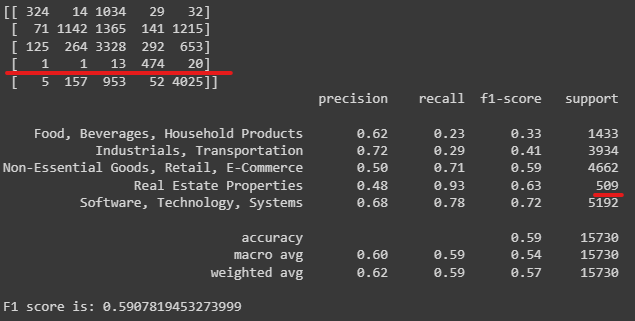

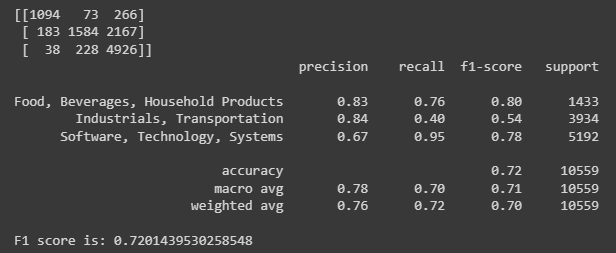